In [3]:
import torch
import pickle
from model import Net  # Ensure this matches your model definition
from dataset import get_custom_dataset  # Ensure this matches your dataset loading function
from torch.utils.data import DataLoader

In [4]:
from dataset import get_custom_dataset, prepare_dataset
import torch
import pickle
from model import Net  # Ensure this matches your model definition
from dataset import get_custom_dataset  # Ensure this matches your dataset loading function
from torch.utils.data import DataLoader

In [5]:
# Load the custom dataset
_, testset = get_custom_dataset(data_path="./data")

# Create a DataLoader for the test dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [6]:
from sklearn.metrics import classification_report


In [7]:
def test_model(model, testloader, device="cpu"):
    """Evaluate the model on the test dataset."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total_loss = 0, 0.0
    model.eval()
    model.to(device)
    y_true, y_pred = [], [] 
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels).item()
            total_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    print('Classification Report: \n', classification_report(y_true, y_pred))
    accuracy = correct / len(testloader.dataset)
    return total_loss, accuracy

In [8]:
!pip install -U ipywidgets

In [16]:
with open("outputs/2024-11-05/10-15-08/results.pkl", "rb") as f:
    model = pickle.load(f)

In [17]:
model

{'history': History (loss, distributed):
 	round 1: 0.15439815998077394
 	round 2: 0.14336144000291823
 History (loss, centralized):
 	round 0: 0.021854744412195988
 	round 1: 0.020796742194738142
 	round 2: 0.019552710728767592
 History (metrics, distributed, evaluate):
 {'federated_evaluate_accuracy': [(1, 0.64), (2, 0.635)]}
 History (metrics, centralized):
 {'accuracy': [(0, 0.625), (1, 0.625), (2, 0.625)]},
 'anythingelse': 'here'}

In [18]:
history = model["history"]
history

History (loss, distributed):
	round 1: 0.15439815998077394
	round 2: 0.14336144000291823
History (loss, centralized):
	round 0: 0.021854744412195988
	round 1: 0.020796742194738142
	round 2: 0.019552710728767592
History (metrics, distributed, evaluate):
{'federated_evaluate_accuracy': [(1, 0.64), (2, 0.635)]}
History (metrics, centralized):
{'accuracy': [(0, 0.625), (1, 0.625), (2, 0.625)]}

In [19]:
history.metrics_centralized['accuracy'], history.metrics_distributed['federated_evaluate_accuracy']

([(0, 0.625), (1, 0.625), (2, 0.625)], [(1, 0.64), (2, 0.635)])

In [20]:
accuracy_centralized = history.metrics_centralized['accuracy']
accuracy_distributed = history.metrics_distributed['federated_evaluate_accuracy']
rounds_centralized = [x[0] for x in accuracy_centralized]
accuracy_centralized_list = [x[1] for x in accuracy_centralized]
rounds_distributed = [ x[0] for x in accuracy_distributed]
accuracy_distributed_list = [x[1] for x in accuracy_distributed]

In [21]:
accuracy_distributed_list, accuracy_centralized_list

([0.64, 0.635], [0.625, 0.625, 0.625])

In [4]:
from model import train,test, Net
from dataset import prepare_dataset_for_centralized_train
##Huan luyen voi du lieu tap trung 
model = Net()

epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)


In [5]:
trainloader, valloader, testloader = prepare_dataset_for_centralized_train(32, 0.1)

Number of train samples: 738, val samples: 83, test samples: 624


In [8]:
#CENTRALIZED TRAINING == CT
loss_val_CT = []
acc_val_CT = []
loss_test_CT = []
acc_test_CT = []

for epoch in range(2):
    train(model, trainloader, optim, epochs, device)
    loss, acc = test(model, valloader, device)
    loss_val_CT.append(loss)
    acc_val_CT.append(acc)
    loss, acc = test(model, testloader, device)
    loss_test_CT.append(loss)
    acc_test_CT.append(acc)

loss_val_CT, acc_val_CT, loss_test_CT, acc_test_CT

Testing...
Testing...
Testing...
Testing...


([0.005724806114133582, 0.003178959577737084],
 [0.927710843373494, 0.963855421686747],
 [0.02344715467487008, 0.03859753237161502],
 [0.7628205128205128, 0.7451923076923077])

In [25]:
import matplotlib.pyplot as plt
import os

In [26]:
# Tạo thư mục nếu chưa tồn tại
output_dir = 'running_outputs'
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(rounds_centralized, accuracy_centralized_list, label="GLOBAL TEST")
plt.plot(rounds_distributed, accuracy_distributed_list, label="Distributed")
plt.plot(range(1, 1 + len(acc_val_CT)), acc_val_CT, label="Centralized (VAL)")
plt.plot(range(1, 1 + len(acc_test_CT)), acc_test_CT, label = "Centralized (TEST)")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Accuracy of Centralized (TEST) vs Distributed(AGGREGATION VAL)")
plt.legend()
plt.xticks(ticks=range(1, max(rounds_centralized) + 1))

# Lưu biểu đồ vào thư mục running_outputs
plt.savefig(os.path.join(output_dir, 'accuracy_comparison.png'))
plt.close()

In [47]:
loss_centralized = history.losses_centralized
loss_distributed = history.losses_distributed

loss_centralized_list = [x[1] for x in loss_centralized]
loss_distributed_list = [x[1] for x in loss_distributed]

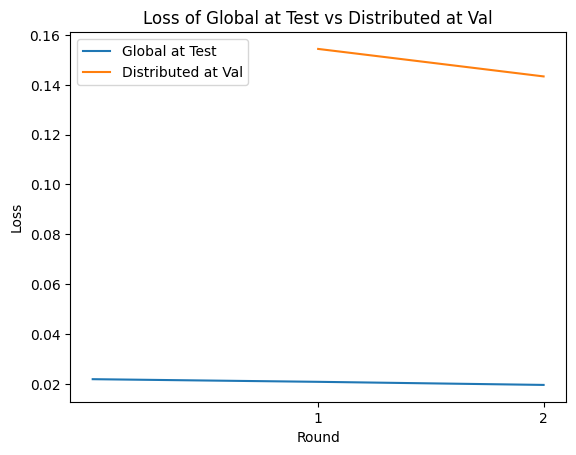

In [57]:
plt.plot(rounds_centralized, loss_centralized_list, label="Global at Test")
plt.plot(rounds_distributed, loss_distributed_list, label="Distributed at Val")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss of Global at Test vs Distributed at Val")
plt.legend()
plt.xticks(ticks=range(1, max(rounds_centralized) + 1))

plt.show()


In [30]:
history.losses_centralized, history.losses_distributed

([(0, 0.021854744412195988),
  (1, 0.020796742194738142),
  (2, 0.019552710728767592)],
 [(1, 0.15439815998077394), (2, 0.14336144000291823)])

In [10]:
# Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss, accuracy = test_model(model, testloader, device)

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

AttributeError: 'dict' object has no attribute 'eval'

In [2]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 562.6 kB/s eta 0:00:001m544.3 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.3 MB/s eta 0:00:00 MB/s eta 0:00:01:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 777.5 kB/s eta 0:00:001m701.4 kB/s eta 0:00:01


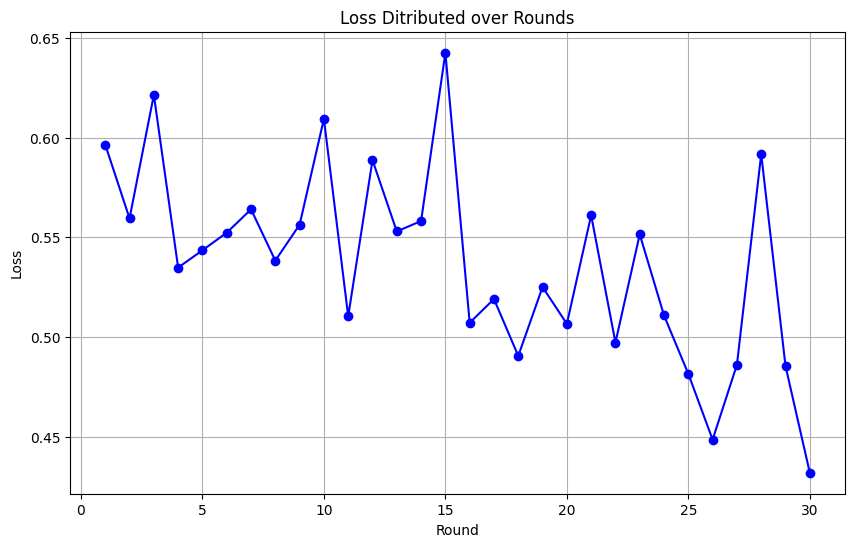

In [5]:
import matplotlib.pyplot as plt

# Loss values extracted from the log
loss_distributed = [
    0.5964988678693771, 0.5594912439584732, 0.621490153670311, 0.5348075479269028, 
    0.5434988856315612, 0.5523316979408264, 0.5640363991260529, 0.5383213996887207, 
    0.5563529580831528, 0.6094510614871979, 0.5103592276573181, 0.5887498557567596, 
    0.5529695689678192, 0.5581783413887024, 0.6426542401313782, 0.5071190237998963, 
    0.5190105468034745, 0.49050275683403016, 0.5250702381134034, 0.506564486026764, 
    0.5610691696405411, 0.49719488322734834, 0.5515137493610383, 0.510778346657753, 
    0.48147799670696256, 0.44845924377441404, 0.48603149503469467, 0.5917705357074737, 
    0.4854150727391243, 0.43185741603374483
]

# Plotting the loss data
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), loss_distributed, marker='o', linestyle='-', color='b')
plt.title('Loss Ditributed over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

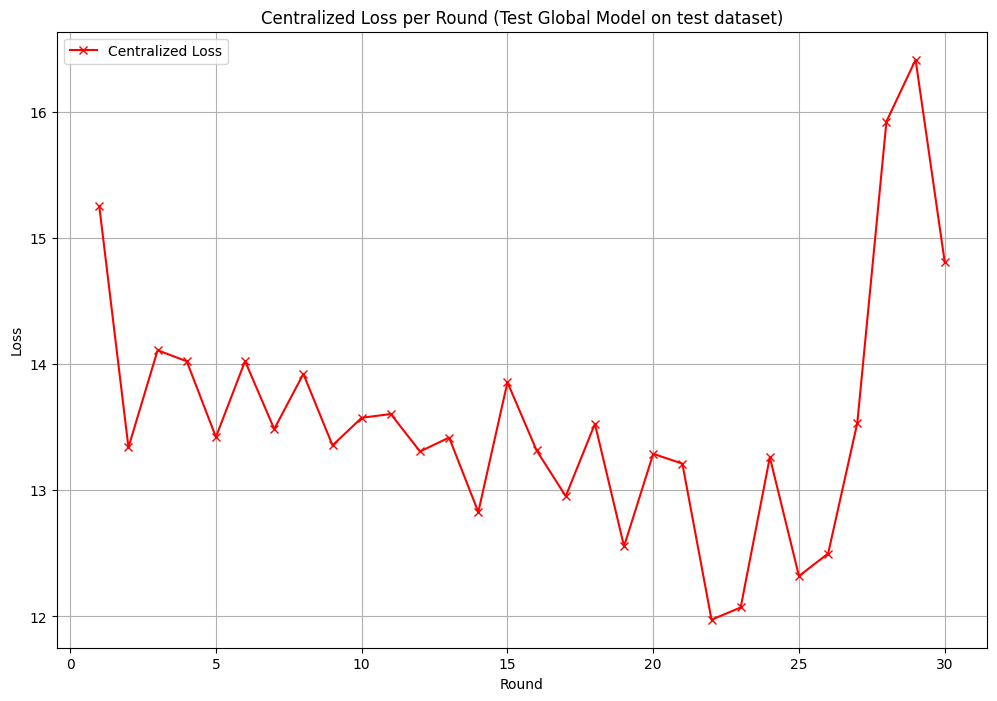

In [12]:
import matplotlib.pyplot as plt



# Centralized loss values
centralized_loss = [
15.252644509077072, 13.340660363435745, 14.111672580242157,
    14.023953825235367, 13.423095911741257, 14.025703638792038, 13.4866241812706,
    13.924203366041183, 13.356942504644394, 13.575874984264374, 13.605706334114075,
    13.30841189622879, 13.418996661901474, 12.827893882989883, 13.857224881649017,
    13.316631942987442, 12.95371687412262, 13.527975171804428, 12.556139349937439,
    13.289991617202759, 13.212051779031754, 11.97389480471611, 12.07108759880066,
    13.263091757893562, 12.320416897535324, 12.499203145503998, 13.534167401492596,
    15.926027186214924, 16.41625388711691, 14.809762589633465
]

rounds = range(1, 31)

# Plotting both distributed and centralized loss
plt.figure(figsize=(12, 8))
plt.plot(rounds, centralized_loss, marker='x', linestyle='-', color='red', label='Centralized Loss')
plt.title('Centralized Loss per Round (Test Global Model on test dataset)')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

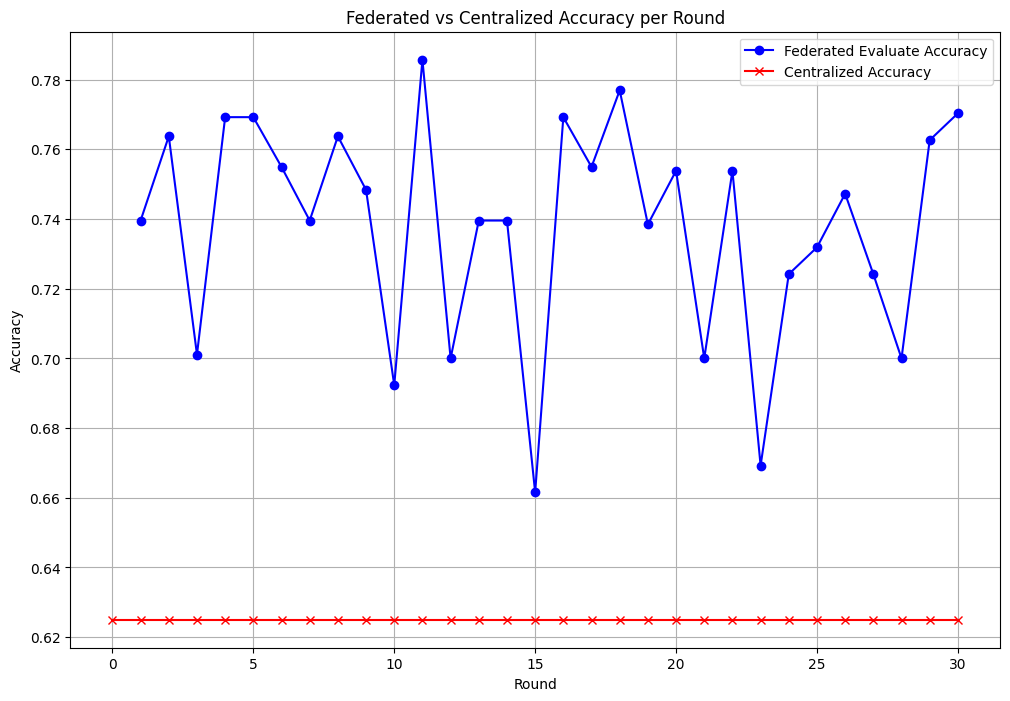

In [11]:
import matplotlib.pyplot as plt

# Federated evaluate accuracy data
federated_accuracy = [
    (1, 0.7395604395604395), (2, 0.7637362637362638), (3, 0.701098901098901),
    (4, 0.7692307692307693), (5, 0.7692307692307693), (6, 0.7549450549450548),
    (7, 0.7395604395604396), (8, 0.7637362637362639), (9, 0.7483516483516482),
    (10, 0.6923076923076923), (11, 0.7857142857142858), (12, 0.7),
    (13, 0.7395604395604396), (14, 0.7395604395604395), (15, 0.6615384615384616),
    (16, 0.7692307692307693), (17, 0.7549450549450549), (18, 0.7769230769230769),
    (19, 0.7384615384615384), (20, 0.7538461538461538), (21, 0.7),
    (22, 0.7538461538461538), (23, 0.6692307692307693), (24, 0.7241758241758242),
    (25, 0.7318681318681318), (26, 0.7472527472527474), (27, 0.7241758241758242),
    (28, 0.7), (29, 0.7626373626373626), (30, 0.7703296703296703)
]

# Centralized accuracy data
centralized_accuracy = [
    (0, 0.625), (1, 0.625), (2, 0.625), (3, 0.625), (4, 0.625), (5, 0.625),
    (6, 0.625), (7, 0.625), (8, 0.625), (9, 0.625), (10, 0.625), (11, 0.625),
    (12, 0.625), (13, 0.625), (14, 0.625), (15, 0.625), (16, 0.625), (17, 0.625),
    (18, 0.625), (19, 0.625), (20, 0.625), (21, 0.625), (22, 0.625), (23, 0.625),
    (24, 0.625), (25, 0.625), (26, 0.625), (27, 0.625), (28, 0.625), (29, 0.625),
    (30, 0.625)
]

# Unpack the rounds and accuracy values
fed_rounds, fed_acc_values = zip(*federated_accuracy)
cen_rounds, cen_acc_values = zip(*centralized_accuracy)

# Plotting both federated and centralized accuracy
plt.figure(figsize=(12, 8))
plt.plot(fed_rounds, fed_acc_values, marker='o', linestyle='-', color='blue', label='Federated Evaluate Accuracy')
plt.plot(cen_rounds, cen_acc_values, marker='x', linestyle='-', color='red', label='Centralized Accuracy')
plt.title('Federated vs Centralized Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


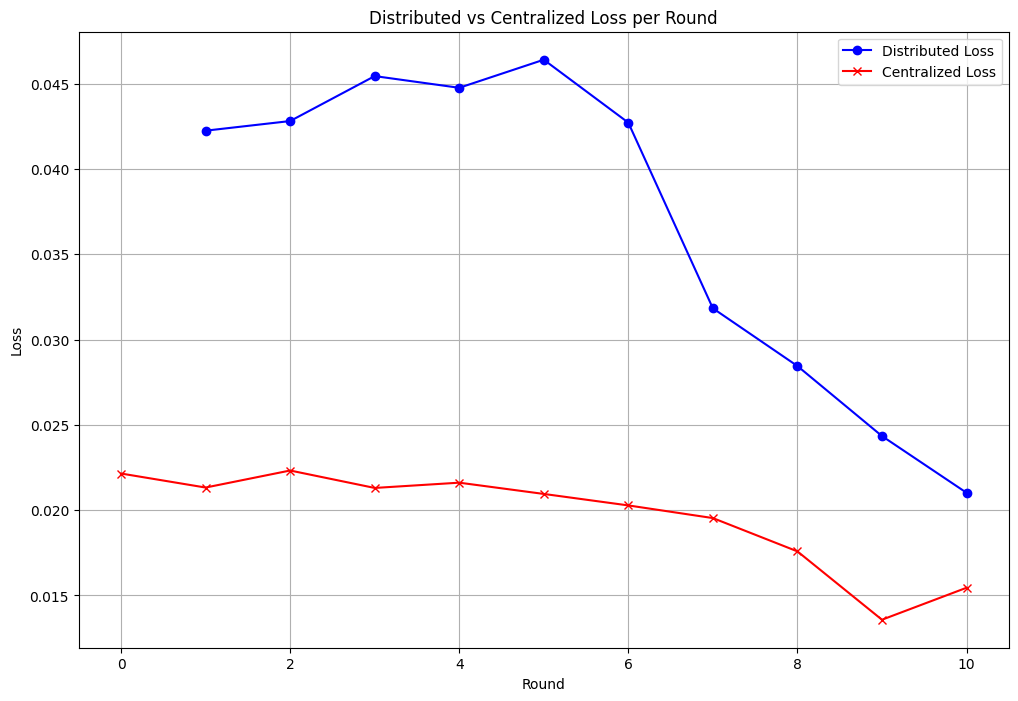

In [13]:
import matplotlib.pyplot as plt

# Distributed loss values
distributed_loss = [
    0.042245744741879976, 0.04281081028364516, 0.045446485510239235, 0.0447600903419348, 
    0.04640601116877336, 0.042716829364116374, 0.031833806175452006, 0.028450577632411496, 
    0.024344953894615173, 0.021021474570363432
]

# Centralized loss values
centralized_loss = [
    0.022147751102844875, 0.021325461327647552, 0.02232427231203287, 0.021301977814008027, 
    0.021611218985456686, 0.02095074005998098, 0.020277630776548997, 0.01953588027316026, 
    0.017584248517568294, 0.013576955964358954, 0.01545018203652058
]

# Define rounds (assuming centralized starts from round 0)
rounds_distributed = range(1, 11)
rounds_centralized = range(0, 11)

# Plotting both distributed and centralized loss
plt.figure(figsize=(12, 8))
plt.plot(rounds_distributed, distributed_loss, marker='o', linestyle='-', color='blue', label='Distributed Loss')
plt.plot(rounds_centralized, centralized_loss, marker='x', linestyle='-', color='red', label='Centralized Loss')
plt.title('Distributed vs Centralized Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


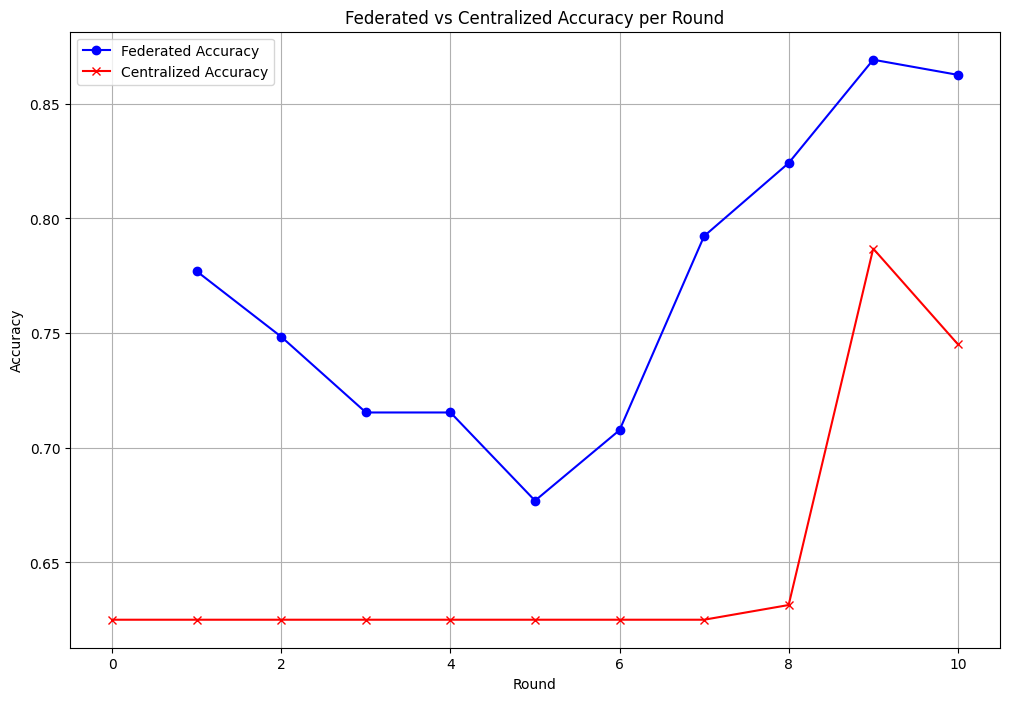

In [14]:
import matplotlib.pyplot as plt

# Federated evaluate accuracy data
federated_accuracy = [
    (1, 0.776923076923077), (2, 0.7483516483516484), (3, 0.7153846153846154),
    (4, 0.7153846153846154), (5, 0.676923076923077), (6, 0.7076923076923076),
    (7, 0.7923076923076924), (8, 0.8241758241758242), (9, 0.8692307692307694),
    (10, 0.8626373626373626)
]

# Centralized accuracy data
centralized_accuracy = [
    (0, 0.625), (1, 0.625), (2, 0.625), (3, 0.625), (4, 0.625), (5, 0.625),
    (6, 0.625), (7, 0.625), (8, 0.6314102564102564), (9, 0.7868589743589743), 
    (10, 0.7451923076923077)
]

# Unpack the rounds and accuracy values
fed_rounds, fed_acc_values = zip(*federated_accuracy)
cen_rounds, cen_acc_values = zip(*centralized_accuracy)

# Plotting both federated and centralized accuracy
plt.figure(figsize=(12, 8))
plt.plot(fed_rounds, fed_acc_values, marker='o', linestyle='-', color='blue', label='Federated Accuracy')
plt.plot(cen_rounds, cen_acc_values, marker='x', linestyle='-', color='red', label='Centralized Accuracy')
plt.title('Federated vs Centralized Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


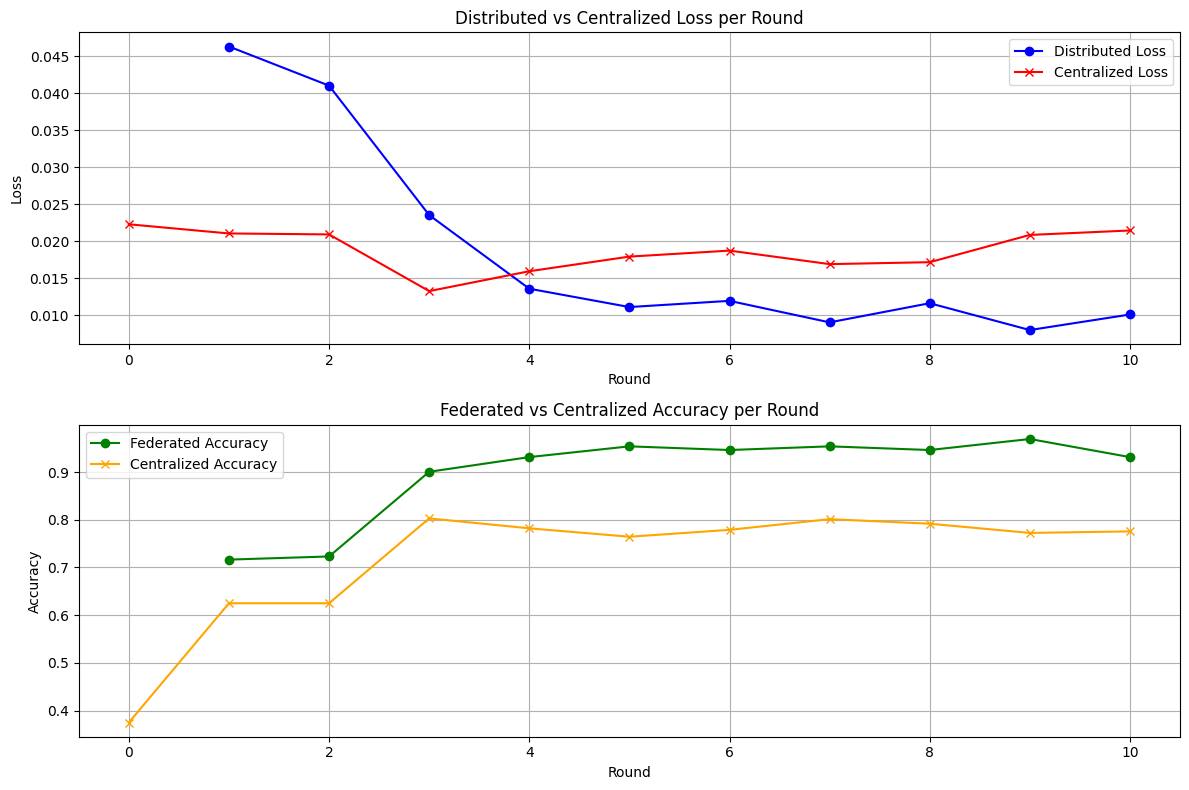

In [15]:
import matplotlib.pyplot as plt

# Distributed loss values
distributed_loss = [
    0.04633024384032238, 0.04103829585588895, 0.023540716970359886, 0.013585522910068324, 
    0.011105279251933099, 0.011942351681108656, 0.009033866527561957, 0.011623176960990978, 
    0.007996086878599701, 0.010098922291545423
]

# Centralized loss values
centralized_loss = [
    0.022293024815810032, 0.02105562431881061, 0.020924905840402994, 0.013259742743311783, 
    0.01594728422470582, 0.017924931031675674, 0.018735287451328568, 0.016909086420081366, 
    0.01717075695677732, 0.020855011308016494, 0.021456657538715847
]

# Federated evaluate accuracy data
federated_accuracy = [
    (1, 0.7164835164835165), (2, 0.7230769230769231), (3, 0.9005494505494506), 
    (4, 0.9313186813186813), (5, 0.953846153846154), (6, 0.9461538461538463), 
    (7, 0.953846153846154), (8, 0.9461538461538461), (9, 0.9692307692307693), 
    (10, 0.9313186813186812)
]

# Centralized accuracy data
centralized_accuracy = [
    (0, 0.375), (1, 0.625), (2, 0.625), (3, 0.8028846153846154), (4, 0.782051282051282), 
    (5, 0.7644230769230769), (6, 0.7788461538461539), (7, 0.8012820512820513), 
    (8, 0.7916666666666666), (9, 0.7724358974358975), (10, 0.7756410256410257)
]

# Plotting the distributed and centralized loss
plt.figure(figsize=(12, 8))
rounds_distributed = range(1, 11)
rounds_centralized = range(0, 11)

plt.subplot(2, 1, 1)
plt.plot(rounds_distributed, distributed_loss, marker='o', linestyle='-', color='blue', label='Distributed Loss')
plt.plot(rounds_centralized, centralized_loss, marker='x', linestyle='-', color='red', label='Centralized Loss')
plt.title('Distributed vs Centralized Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Unpack the accuracy values for federated and centralized accuracy
fed_rounds, fed_acc_values = zip(*federated_accuracy)
cen_rounds, cen_acc_values = zip(*centralized_accuracy)

# Plotting the federated and centralized accuracy
plt.subplot(2, 1, 2)
plt.plot(fed_rounds, fed_acc_values, marker='o', linestyle='-', color='green', label='Federated Accuracy')
plt.plot(cen_rounds, cen_acc_values, marker='x', linestyle='-', color='orange', label='Centralized Accuracy')
plt.title('Federated vs Centralized Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


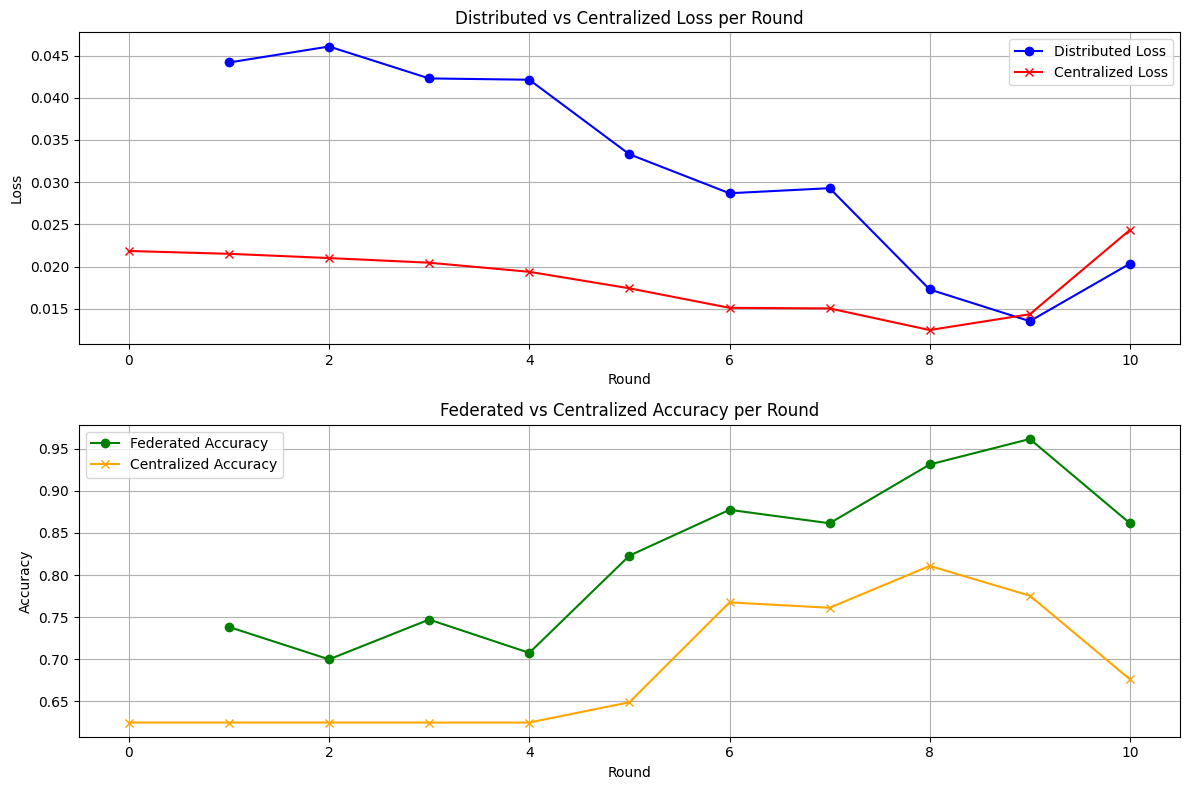

In [16]:
import matplotlib.pyplot as plt

# Distributed loss values
distributed_loss = [
    0.044175861432002146, 0.04606862664222717, 0.04228819870686793, 0.042131694692831775, 
    0.033301259233401374, 0.028686175061451213, 0.02928686439990997, 0.017284850424135124, 
    0.01353255957365036, 0.02034735951859217
]

# Centralized loss values
centralized_loss = [
    0.021845342066043463, 0.021512813579577666, 0.021008276786559667, 0.02045806635839817, 
    0.019381541424454786, 0.01742521286583864, 0.015113608242991643, 0.015044449422603998, 
    0.012481543426521314, 0.014356138817488383, 0.024341591636841305
]

# Federated evaluate accuracy data
federated_accuracy = [
    (1, 0.7384615384615385), (2, 0.7000000000000001), (3, 0.7472527472527472), 
    (4, 0.7076923076923076), (5, 0.823076923076923), (6, 0.8774725274725276), 
    (7, 0.8615384615384617), (8, 0.9313186813186813), (9, 0.9615384615384617), 
    (10, 0.8615384615384617)
]

# Centralized accuracy data
centralized_accuracy = [
    (0, 0.625), (1, 0.625), (2, 0.625), (3, 0.625), (4, 0.625), (5, 0.6490384615384616), 
    (6, 0.7676282051282052), (7, 0.7612179487179487), (8, 0.8108974358974359), 
    (9, 0.7756410256410257), (10, 0.6762820512820513)
]

# Plotting the distributed and centralized loss
plt.figure(figsize=(12, 8))
rounds_distributed = range(1, 11)
rounds_centralized = range(0, 11)

plt.subplot(2, 1, 1)
plt.plot(rounds_distributed, distributed_loss, marker='o', linestyle='-', color='blue', label='Distributed Loss')
plt.plot(rounds_centralized, centralized_loss, marker='x', linestyle='-', color='red', label='Centralized Loss')
plt.title('Distributed vs Centralized Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Unpack the accuracy values for federated and centralized accuracy
fed_rounds, fed_acc_values = zip(*federated_accuracy)
cen_rounds, cen_acc_values = zip(*centralized_accuracy)

# Plotting the federated and centralized accuracy
plt.subplot(2, 1, 2)
plt.plot(fed_rounds, fed_acc_values, marker='o', linestyle='-', color='green', label='Federated Accuracy')
plt.plot(cen_rounds, cen_acc_values, marker='x', linestyle='-', color='orange', label='Centralized Accuracy')
plt.title('Federated vs Centralized Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
